# Investigating clustering

## Investigating the structure of the data to consider clustering 

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
%matplotlib inline

In [120]:
#import data

#Read in dataset with all rows included
df = pd.read_sas("Data/alldata3.sas7bdat")

scaler = StandardScaler()

df["age_sd"] = scaler.fit_transform(df[["AGE_YEARS"]])

#6931 DBD apps
dbd_apps = df[(df["eli_DBD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#6060 DBD apps to match cohort in pape
dbd_apps = dbd_apps[(dbd_apps["eth_grp"]!=5)&(dbd_apps["FORMAL_APR_WHEN"]!=4)&(dbd_apps["donation_mentioned"]!=-1)
                    &(dbd_apps["FAMILY_WITNESS_BSDT"]!=9)&(dbd_apps["GENDER"]!=9)]
     
#9965 DCD apps
dcd_apps = df[(df["eli_DCD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#9405 DCD apps to match cohort in paper
dcd_apps = dcd_apps[(dcd_apps["GENDER"]!=9)&(dcd_apps["cod_neuro"].notna())&(dcd_apps["eth_grp"]!=5)&(dcd_apps["donation_mentioned"]!=-1)&
                    (~dcd_apps["DTC_WD_TRTMENT_PRESENT"].isin([8,9]))]

# Consented donors only
dbd_cons = dbd_apps[dbd_apps["FAMILY_CONSENT"]==2]
dcd_cons = dcd_apps[dcd_apps["FAMILY_CONSENT"]==2]

/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [121]:
# Columns used to create DBD model in paper
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "age_sd", "FAMILY_CONSENT"]

dbd_cats = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "FAMILY_CONSENT"]

dbd_apps[dbd_cats].astype(int)

dbd_model_data = dbd_apps[dbd_cols]
dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cats[:-1],drop_first=True)

# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "age_sd","cod_neuro","FAMILY_CONSENT"]

dcd_cats = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "cod_neuro","FAMILY_CONSENT"]

dcd_apps[dbd_cats].astype(int)

dcd_model_data = dcd_apps[dcd_cols]
dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cats[:-1],drop_first=True)

In [142]:
dbd_model_data.corr()

,wish,FORMAL_APR_WHEN,donation_mentioned,app_nature,eth_grp,religion_grp,GENDER,FAMILY_WITNESS_BSDT,DTC_PRESENT_BSD_CONV,acorn_new,age_sd,FAMILY_CONSENT
wish,1.000000,-0.104235,0.165343,-0.013354,-0.119889,0.051432,0.045401,-0.035915,-0.030802,-0.059632,-0.008399,0.325535
FORMAL_APR_WHEN,-0.104235,1.000000,-0.136840,-0.053805,0.087671,-0.010705,-0.006166,0.053873,0.004633,0.082837,-0.031310,-0.169023
donation_mentioned,0.165343,-0.136840,1.000000,-0.030924,-0.097764,-0.011673,-0.008545,-0.022047,-0.105269,-0.017517,-0.110885,0.177850
app_nature,-0.013354,-0.053805,-0.030924,1.000000,-0.024932,0.058073,-0.001072,-0.060159,-0.133587,-0.004706,-0.032319,-0.079319
eth_grp,-0.119889,0.087671,-0.097764,-0.024932,1.000000,-0.164207,-0.022516,0.131699,0.009488,0.068999,-0.083465,-0.216963
religion_grp,0.051432,-0.010705,-0.011673,0.058073,-0.164207,1.000000,-0.024375,-0.076031,-0.077683,-0.046742,0.023245,0.025758
GENDER,0.045401,-0.006166,-0.008545,-0.001072,-0.022516,-0.024375,1.000000,-0.027920,0.009730,-0.009488,0.092148,-0.011366
FAMILY_WITNESS_BSDT,-0.035915,0.053873,-0.022047,-0.060159,0.131699,-0.076031,-0.027920,1.000000,0.098169,0.002491,-0.097532,-0.082200
DTC_PRESENT_BSD_CONV,-0.030802,0.004633,-0.105269,-0.133587,0.009488,-0.077683,0.009730,0.098169,1.000000,-0.030432,0.046432,0.049363
acorn_new,-0.059632,0.082837,-0.017517,-0.004706,0.068999,-0.046742,-0.009488,0.002491,-0.030432,1.000000,-0.143070,-0.094259


In [205]:
pca = PCA(n_components=3)
pca.fit(dbd_model_data)
print(pca.explained_variance_ratio_)

dbd_pca = pd.DataFrame(pca.transform(dbd_model_data),columns=["A","B","C"])

[0.5798148  0.13190925 0.09621987]


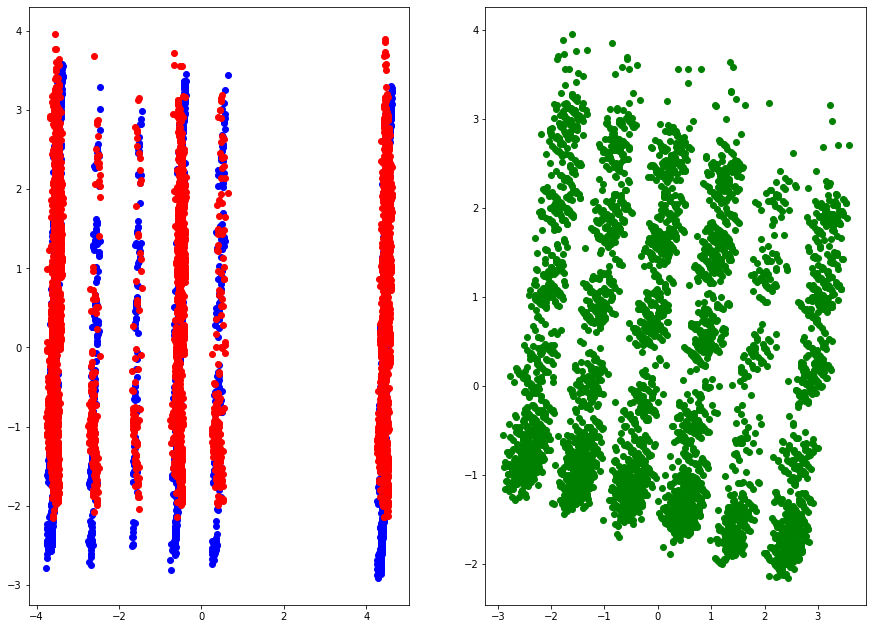

In [206]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=[15,11],facecolor="white")
ax1.set_facecolor("white")
ax2.set_facecolor("white")

ax1.plot(dbd_pca["A"],dbd_pca["B"],"bo")
ax1.plot(dbd_pca["A"],dbd_pca["C"],"ro")
ax2.plot(dbd_pca["B"],dbd_pca["C"],"go")

In [192]:
kmeans_dbd = KMeans(n_clusters=5,random_state=66)
kmeans_dbd.fit(dbd_pca)

dbd_km = pd.concat([dbd_model_data.reset_index(drop=True),dbd_pca],axis=1)
dbd_km["KM clusters"] = kmeans_dbd.labels_
dbd_km["Label"] = dbd_km["KM clusters"].map({0:"Group 1",1:"Group 2",2:"Group 3",3:"Group 4",4:"Group 5",5:"Group 6"})
dbd_km["Colour"] = dbd_km["KM clusters"].map({0:"red",1:"green",2:"blue",3:"yellow",4:"purple",5:"orange"})

dbd_km["Label"].value_counts()

for c in [0,1,2,3,4,5]:
    print("For Group" + str(c+1) + ":")
    print(dbd_km[dbd_km["KM clusters"]==c]["religion_grp"].value_counts())

For Group1:
1.0    1377
2.0     165
3.0      11
Name: religion_grp, dtype: int64
For Group2:
9.0    1212
Name: religion_grp, dtype: int64
For Group3:
1.0    919
4.0    202
2.0     71
3.0     24
Name: religion_grp, dtype: int64
For Group4:
9.0    911
Name: religion_grp, dtype: int64
For Group5:
4.0    921
5.0    188
3.0     59
Name: religion_grp, dtype: int64
For Group6:
Series([], Name: religion_grp, dtype: int64)


<AxesSubplot:xlabel='A', ylabel='B'>

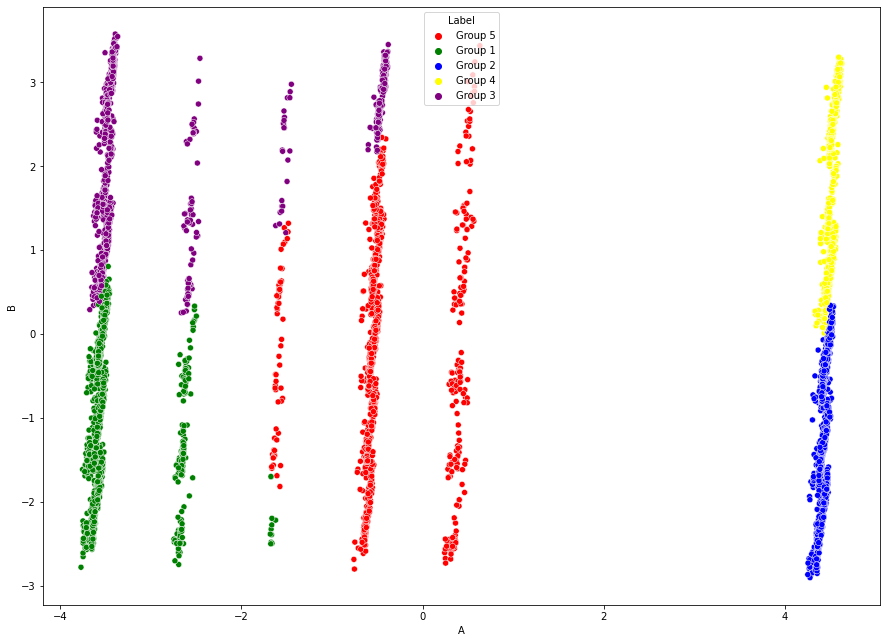

In [194]:
fig,ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

sns.scatterplot(data=dbd_km,x="A",y="B",hue=dbd_km["Label"],palette=["red","green","blue","yellow","purple"])
#sns.scatterplot(data=dbd_km,x="B",y="A",hue=dbd_km["Label"],palette=["red","green","blue"])

<AxesSubplot:xlabel='B', ylabel='C'>

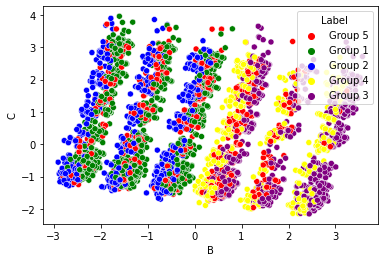

In [190]:
sns.scatterplot(data=dbd_km,x="B",y="C",hue=dbd_km["Label"],palette=["red","green","blue","yellow",""])

In [151]:
spectral_dbd = SpectralClustering(n_clusters=6,random_state=66)
spectral_dbd.fit(dbd_pca)

dbd_spectral = pd.concat([dbd_model_data.reset_index(drop=True),dbd_pca],axis=1)
dbd_spectral["Spec clusters"] = spectral_dbd.labels_
dbd_spectral["Label"] = dbd_spectral["Spec clusters"].map({0:"Group 1",1:"Group 2",2:"Group 3",3:"Group 4",4:"Group 5",5:"Group 6"})

dbd_spectral["Label"].value_counts()

Group 6    1739
Group 2    1582
Group 4     950
Group 1     813
Group 3     592
Group 5     384
Name: Label, dtype: int64

<AxesSubplot:xlabel='A', ylabel='B'>

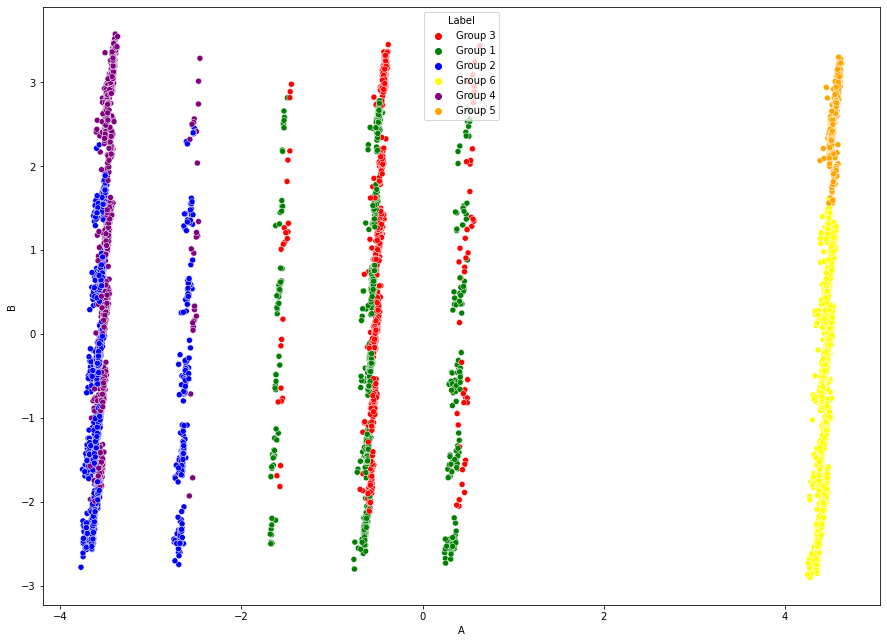

In [152]:
fig,ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

sns.scatterplot(data=dbd_spectral,x="A",y="B",hue=dbd_spectral["Label"],palette=["red","green","blue","yellow","purple","orange"])


<AxesSubplot:xlabel='B', ylabel='C'>

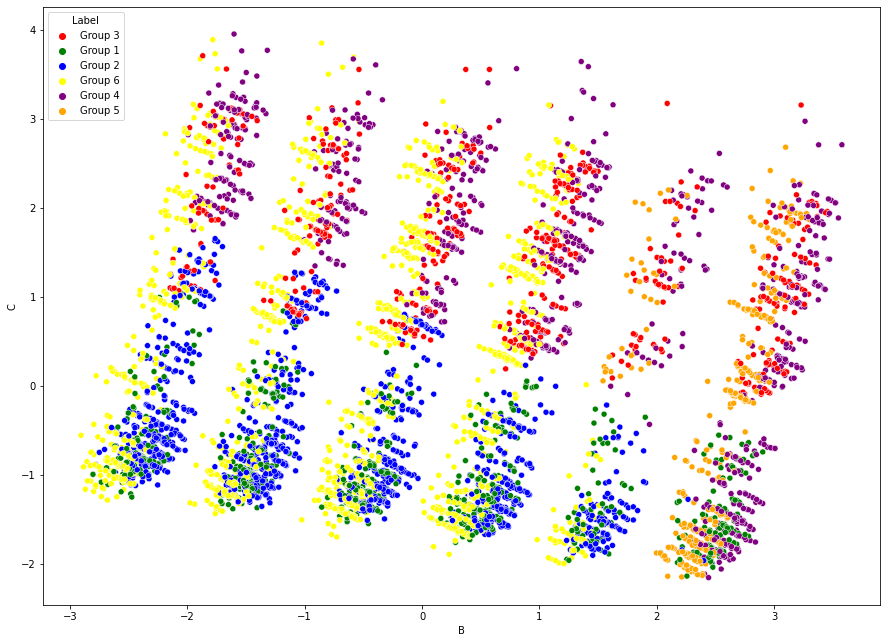

In [191]:
fig,ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

sns.scatterplot(data=dbd_spectral,x="B",y="C",hue=dbd_spectral["Label"],palette=["red","green","blue","yellow","purple","orange"])


In [93]:
pca = PCA(n_components=3)
pca.fit(dcd_model_data)
print(pca.explained_variance_ratio_)

dcd_pca = pd.DataFrame(pca.transform(dcd_model_data),columns=["A","B","C"])

[0.62135895 0.12935361 0.1015546 ]


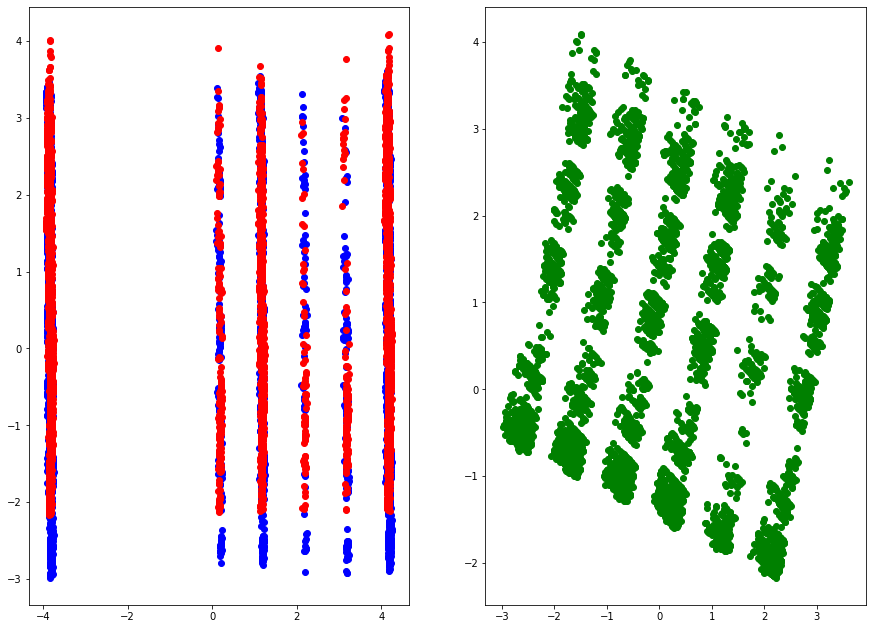

In [94]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=[15,11],facecolor="white")
ax1.set_facecolor("white")
ax2.set_facecolor("white")

ax1.plot(dcd_pca["A"],dcd_pca["B"],"bo")
ax1.plot(dcd_pca["A"],dcd_pca["C"],"ro")
ax2.plot(dcd_pca["B"],dcd_pca["C"],"go")